In [1]:
from IndividualParcellation.global_config import *
import pickle
import numpy as np
import pandas as pd
import torch as pt
import nitools as nt
import seaborn as sns
import SUITPy.flatmap as flatmap
import matplotlib.pyplot as plt
import nilearn.plotting as plotting
from Functional_Fusion.dataset import DataSetMDTB
from Functional_Fusion.dataset import DataSetLanguage
import Functional_Fusion.atlas_map as am
import HierarchBayesParcel.full_model as fm
import HierarchBayesParcel.util as ut
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.evaluation as ev
import PcmPy as pcm
import os
from scipy.stats import pearsonr,linregress


# Constants

For this analysis , I will use a mask that includes D + S regions

In [2]:
# Define ROIs to be used for the analysis
base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
if not os.path.exists(base_dir):
    base_dir = 'Y:/data/FunctionalFusion'
ROI_cerebellum=['S1L', 'S1R', 'S2L', 'S2R', 'S3L', 'S3R', 'S4L', 'S4R','D1L', 'D1R', 'D2L', 'D2R', 'D3L', 'D3R', 'D4L', 'D4R']
ROI_cortex = [6,7] # only used if space is fs32k
space = 'SUIT3'
atlas, _ = am.get_atlas(space)

In [3]:
# Check if CUDA is available
device = pt.device('cuda' if pt.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
if space == 'fs32k':
    atlas_dir = f'{base_dir}/Atlases/tpl-fs32k'
    model_name_L = f'{atlas_dir}/yeo7.L.label.gii'
    model_name_R = f'{atlas_dir}/yeo7.R.label.gii'

    yeo_parcels = atlas.read_data([model_name_L,model_name_R])
    ROI_mask = np.isin(yeo_parcels, ROI_cortex).astype(int)

elif space == 'SUIT3':
    atlas_dir = f'{base_dir}/Atlases/tpl-SUIT'
    model_name = f'/atl-NettekovenSym32_space-SUIT_dseg.nii'
    U = atlas.read_data(atlas_dir + model_name)
    U = U.T
    _, cmap, labels = nt.read_lut(f'{atlas_dir}/atl-NettekovenSym32.lut')
    ROI_mask = np.zeros_like(U)
    for i, label in enumerate(labels):
        if label in ROI_cerebellum:
            ROI_mask[U == i] = 1

else:
    print('atlas space not supported')

# Question 1: Does the COV group covariance matrix look like averaged individual matrices?
A: No group has averaged data so much less noise so lower variances on the diagonal can be seen. But structure is mostly the same.

# Question 2: Does the 2nd moment group matrix look like averaged individual matries?
A: Yes because you reduce the noise so they look so much alike. More than non crossvalidated versions.

# Cov-  group covariance

In [5]:
MDTB_dataset = DataSetMDTB(f'{base_dir}/MDTB')
data_mdtb_s1,info_mdtb_1  =MDTB_dataset.get_data(space=space,ses_id='ses-s1',type='CondAll')
task_names = info_mdtb_1.cond_name.values

<Axes: >

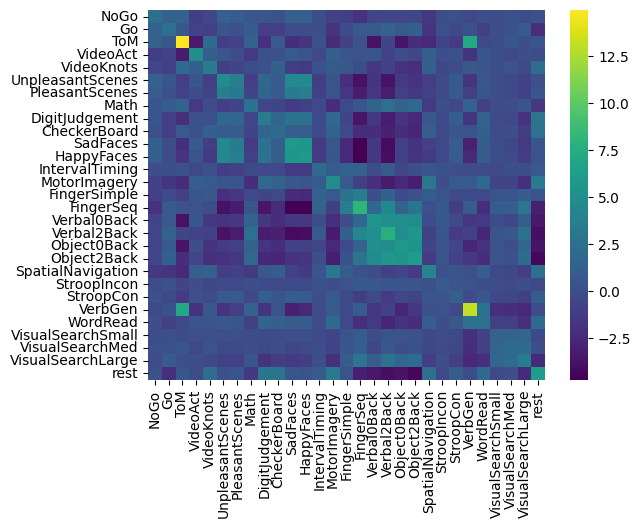

In [6]:
# mask the data
data_mdtb_s1 = data_mdtb_s1 * ROI_mask

#remove nans
data_mdtb_s1[np.isnan(data_mdtb_s1)] = 0

# avg
avg = np.mean(data_mdtb_s1, axis=0)

#get cov matrix
cov = avg @ avg.T
sns.heatmap(cov, cmap='viridis', xticklabels=task_names, yticklabels=task_names)

# Cov Individual covariances


<Axes: >

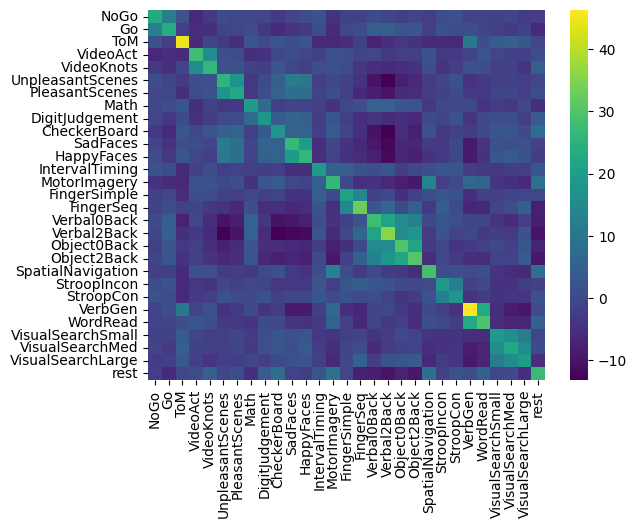

In [7]:
cov_list = []
for i in range(data_mdtb_s1.shape[0]):
    cov = data_mdtb_s1[i] @ data_mdtb_s1[i].T
    cov_list.append(cov)
covs_stacked = np.stack(cov_list, 0)
cov_mean = np.mean(covs_stacked, axis=0)

sns.heatmap(cov_mean, cmap='viridis', xticklabels=task_names, yticklabels=task_names)

# 2nd moment group covariance

In [8]:
MDTB_dataset = DataSetMDTB(f'{base_dir}/MDTB')
data_mdtb_s1,info_mdtb_1  =MDTB_dataset.get_data(space=space,ses_id='ses-s1',type='CondRun')

task_matrix = data_mdtb_s1 * ROI_mask
task_matrix[np.isnan(task_matrix)] = 0


<Axes: >

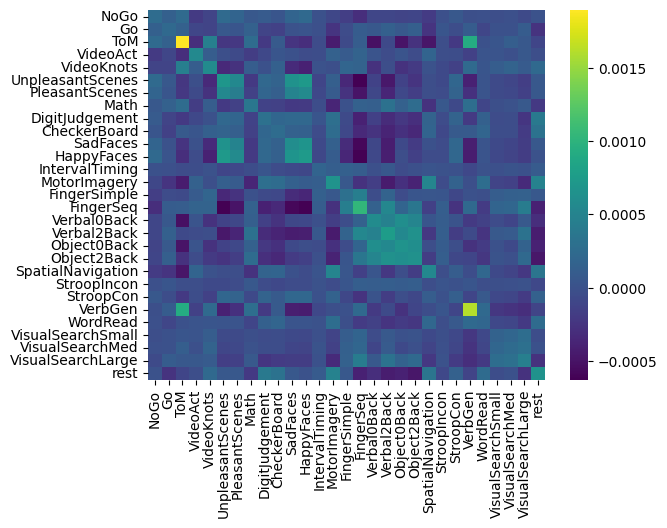

In [9]:
cond_vec = np.tile(np.arange(1, 29 + 1), 16)
part_vec = np.repeat(np.arange(1, 16 + 1), 29)

avg_task_matrix = np.mean(task_matrix, axis=0)
G_group,E_group = pcm.util.est_G_crossval(avg_task_matrix, cond_vec, part_vec)

sns.heatmap(G_group, cmap='viridis', xticklabels=task_names, yticklabels=task_names)


# 2nd moment individual covariances

<Axes: >

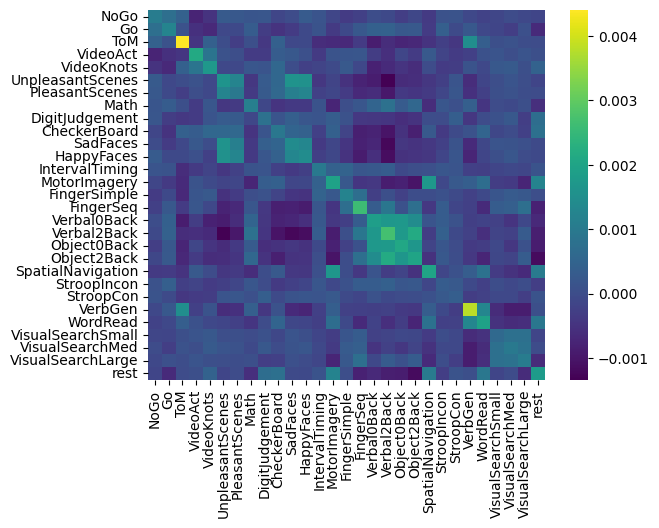

In [10]:
Gs_list = []
E_list = []
for i in range(task_matrix.shape[0]):
    Gs,E = pcm.util.est_G_crossval(task_matrix[i], cond_vec, part_vec)
    Gs_list.append(Gs)
    E_list.append(E)

Gs_list = np.stack(Gs_list, 0)
G_individuals_averaged = np.mean(Gs_list, axis=0)

sns.heatmap(G_individuals_averaged, cmap='viridis', xticklabels=task_names, yticklabels=task_names)

# Question 3: If we regress out the group covarinace from the individual covariances and then average. Do we get anything left?
A: it does seem like tasks that activate same regions/functions are more correlated in individual matrices than in groups

In [11]:
# Compute Group-Average Pattern
group_avg_pattern = np.mean(task_matrix, axis=0)  

residuals = []
for i in range(task_matrix.shape[0]):
    individual_pattern = task_matrix[i]  
    
    # individual_pattern = beta * group_avg_pattern + residual
    individual_flat = individual_pattern.flatten()
    group_flat = group_avg_pattern.flatten()
    
    # Calculate beta
    beta = np.sum(group_flat * individual_flat) / np.sum(group_flat**2)
    
    # Compute the residual pattern
    individual_residual = individual_pattern - beta * group_avg_pattern
    
    residuals.append(individual_residual)

# Convert residuals list to a numpy array
residuals = np.stack(residuals, axis=0)  # s x n x p

#Calculate Covariance Matrix for Each Individual's Residuals
residual_covariances = []
for i in range(residuals.shape[0]):
    individual_residual = residuals[i]  # n x p
    G_s,E_s = pcm.util.est_G_crossval(individual_residual, cond_vec, part_vec)
    residual_covariances.append(G_s) 

# Avg the 2nd moments of individual residuals
residual_cov_mean = np.mean(np.stack(residual_covariances, axis=0), axis=0)



check correlation between a subjects residual and the group average, should be zero or very close to it


In [19]:
sub_res = residuals[10]
sub_res_flat = sub_res.flatten()
group_avg_flat = group_avg_pattern.flatten()

corr, _ = pearsonr(sub_res_flat, group_avg_flat)
print(corr)


-1.0972125985553305e-16


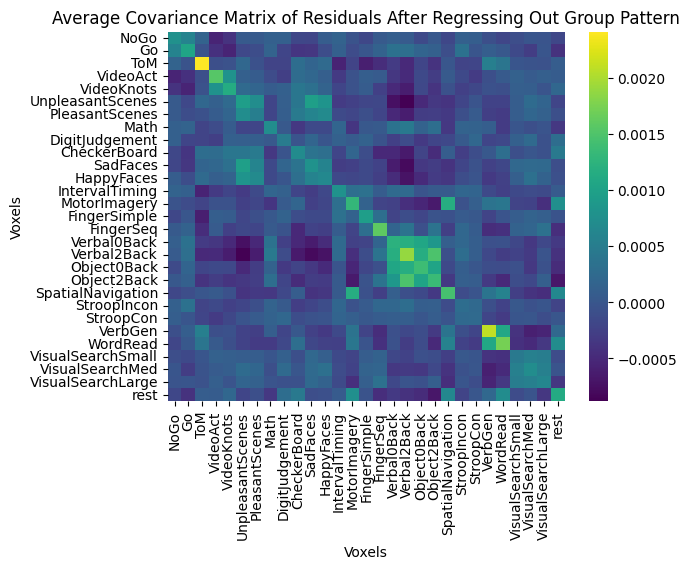

In [13]:
#plot
sns.heatmap(residual_cov_mean, xticklabels=task_names, yticklabels=task_names, cmap='viridis')
plt.title('Average Covariance Matrix of Residuals After Regressing Out Group Pattern')
plt.xlabel('Voxels')
plt.ylabel('Voxels')
plt.show()

# Question 4: What tasks show more components in the group or in the individual and what task pairs more/less correlated in group/individual?

In [14]:
group_variances = np.diag(G_group)
avg_residual_variances = np.diag(residual_cov_mean)

Text(0, 0.5, 'Group Variances')

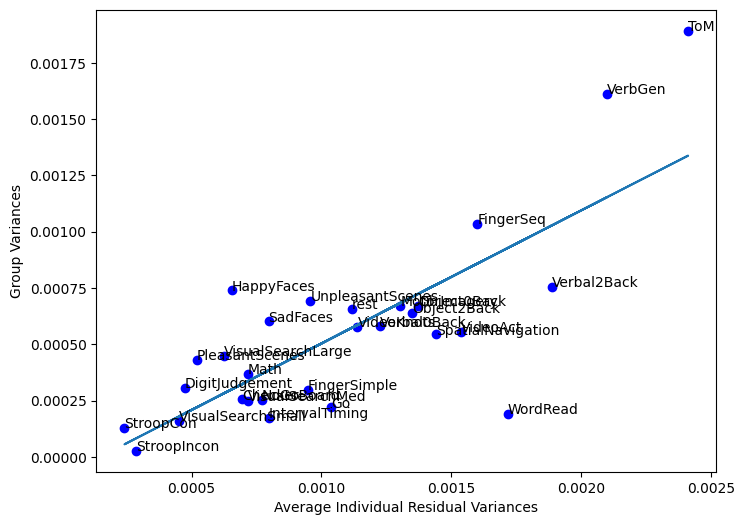

In [15]:
#regress 
slope, intercept, r_value, _, _ = linregress(avg_residual_variances, group_variances)

# Generate fitted line values
fitted_values = intercept + slope * avg_residual_variances

plt.figure(figsize=(8, 6))
plt.scatter(avg_residual_variances, group_variances, color='blue', label='Tasks')

# Plot the fitted regression line
plt.plot(avg_residual_variances, fitted_values)


# label points
for i, task in enumerate(task_names):
    plt.annotate(task, (avg_residual_variances[i], group_variances[i]))

plt.xlabel('Average Individual Residual Variances')
plt.ylabel('Group Variances')




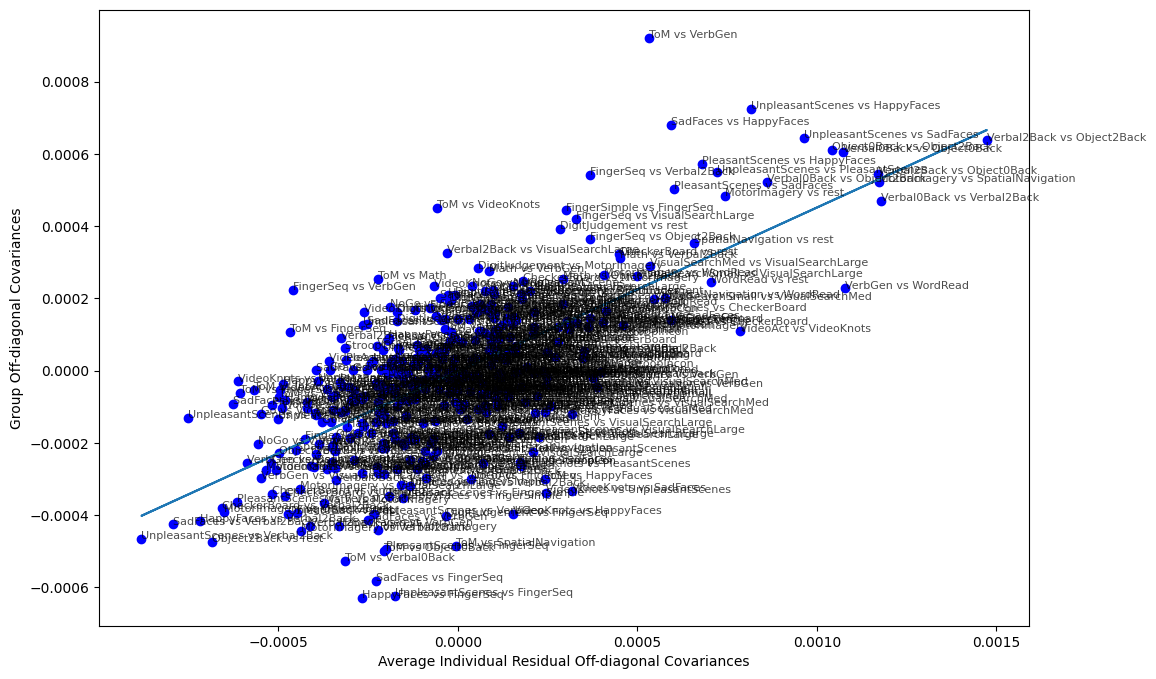

In [16]:
def get_off_diagonal_elements_with_labels(matrix, labels):
    rows, cols = matrix.shape
    # Extract the upper-triangle elements excluding diagonal
    off_diagonal_elements = matrix[np.triu_indices(rows, k=1)]
    
    # Create labels for each pair of tasks
    label_pairs = []
    for i in range(rows):
        for j in range(i + 1, cols):
            label_pairs.append(f'{labels[i]} vs {labels[j]}')
    
    return off_diagonal_elements, label_pairs

# Extract off-diagonal elements
group_off_diagonals, task_pairs_group = get_off_diagonal_elements_with_labels(G_group, task_names)
residual_off_diagonals, task_pairs_residual = get_off_diagonal_elements_with_labels(residual_cov_mean, task_names)

# Ensure labels match
assert task_pairs_group == task_pairs_residual, "Task pairs for group and residual must match"

#reg
slope, intercept, r_value, _, _ = linregress(residual_off_diagonals, group_off_diagonals)

fitted_values = intercept + slope * residual_off_diagonals

plt.figure(figsize=(12, 8))
plt.scatter(residual_off_diagonals, group_off_diagonals, color='blue')


plt.plot(residual_off_diagonals, fitted_values)

# label
for i, label in enumerate(task_pairs_group):
    plt.annotate(label, (residual_off_diagonals[i], group_off_diagonals[i]), fontsize=8, alpha=0.7)

plt.xlabel('Average Individual Residual Off-diagonal Covariances')
plt.ylabel('Group Off-diagonal Covariances')
plt.show()



hard to read since the scaling is different so convert cov matrices into correlations and plot

In [21]:
def cov_to_corr(cov_matrix):
    std_devs = np.sqrt(np.diag(cov_matrix))
    D_inv = np.diag(1 / std_devs)
    corr_matrix = D_inv @ cov_matrix @ D_inv
    return corr_matrix

G_group_correlation = cov_to_corr(G_group)
residual_cov_mean_correlation = cov_to_corr(residual_cov_mean)

<Axes: >

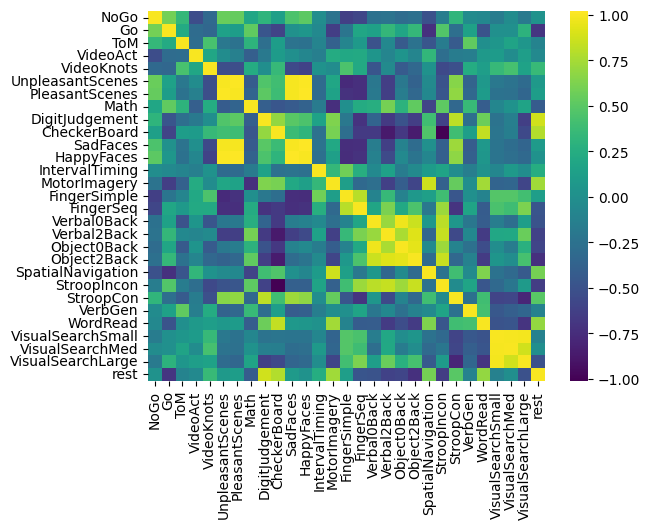

In [22]:
sns.heatmap(G_group_correlation, cmap='viridis', xticklabels=task_names, yticklabels=task_names)

<Axes: >

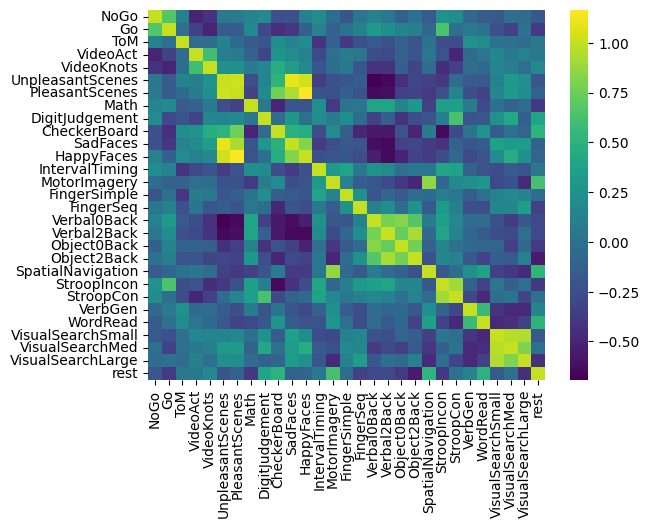

In [23]:
sns.heatmap(residual_cov_mean_correlation, cmap='viridis', xticklabels=task_names, yticklabels=task_names)


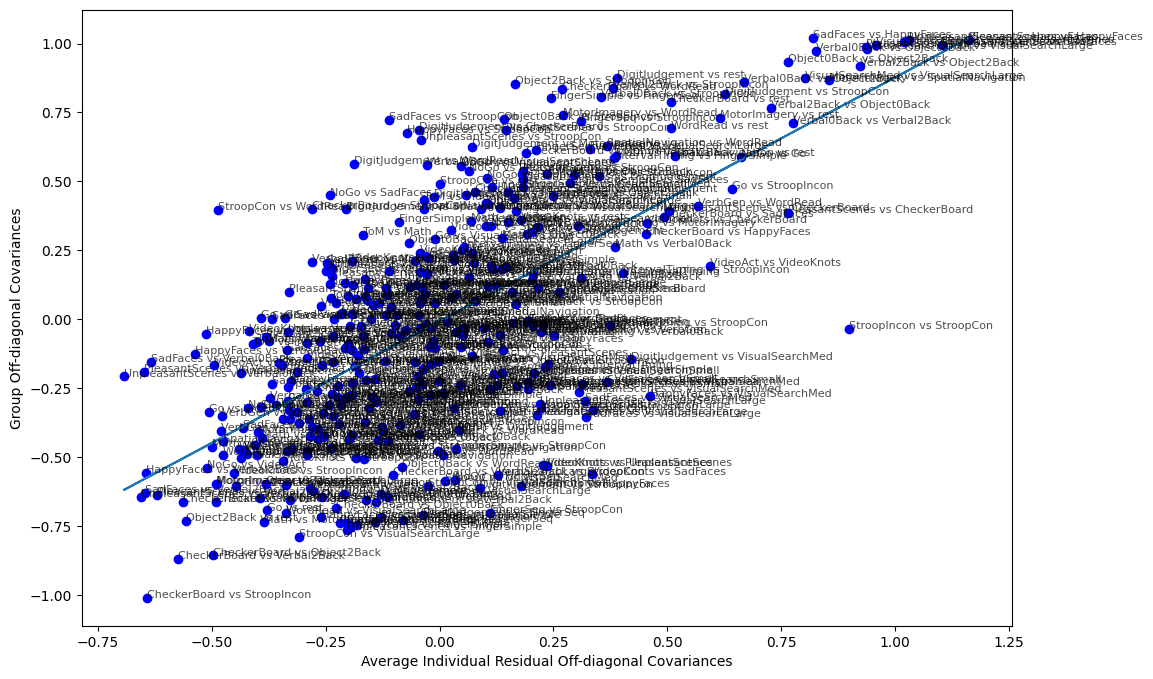

In [24]:
# Extract off-diagonal elements
group_off_diagonals, task_pairs_group = get_off_diagonal_elements_with_labels(G_group_correlation, task_names)
residual_off_diagonals, task_pairs_residual = get_off_diagonal_elements_with_labels(residual_cov_mean_correlation, task_names)

# Ensure labels match
assert task_pairs_group == task_pairs_residual, "Task pairs for group and residual must match"

#reg
slope, intercept, r_value, _, _ = linregress(residual_off_diagonals, group_off_diagonals)

fitted_values = intercept + slope * residual_off_diagonals

plt.figure(figsize=(12, 8))
plt.scatter(residual_off_diagonals, group_off_diagonals, color='blue')


plt.plot(residual_off_diagonals, fitted_values)

# label
for i, label in enumerate(task_pairs_group):
    plt.annotate(label, (residual_off_diagonals[i], group_off_diagonals[i]), fontsize=8, alpha=0.7)

plt.xlabel('Average Individual Residual Off-diagonal Covariances')
plt.ylabel('Group Off-diagonal Covariances')
plt.show()
